<a href="https://colab.research.google.com/github/kavyajeetbora/ETL_wages/blob/master/WIOD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installation and Import

```python
world_industry_values.to_excel('filename.xlsx')
```

In [1]:
%%time
# !wget https://dataverse.nl/api/access/datafile/199104 -O wiot.zip
!wget -q https://dataverse.nl/api/access/datafile/199097 -O exchange_rates.xlsx
!wget -q https://dataverse.nl/api/access/datafile/199095 -O sea.xlsx
!wget -q https://dataverse.nl/api/access/datafile/354108 -O NA_data.xlsx
!wget -q https://raw.githubusercontent.com/kavyajeetbora/ETL_wages/master/data/PPP_export.csv -O ppp.csv

CPU times: user 70.6 ms, sys: 8.7 ms, total: 79.3 ms
Wall time: 3.57 s


In [2]:
import pandas as pd
from zipfile import ZipFile
from tqdm import tqdm
import seaborn as sns
# from pyxlsb import open_workbook as open_xlsb

## SEA

In [3]:
%%time
sea = pd.read_excel("sea.xlsx", sheet_name='DATA')

CPU times: user 15.7 s, sys: 378 ms, total: 16 s
Wall time: 23.6 s


In [4]:
sea.head(3)

,country,variable,description,code,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,AUS,CAP,"Crop and animal production, hunting and relate...",A01,9739.77,13729.03,9726.30,11808.62,11163.98,12429.90,8706.66,11227.29,12556.71,13768.79,18441.27,20106.04,19659.28,18986.06,20525.22
1,AUS,CAP,Forestry and logging,A02,582.69,740.04,540.79,651.96,649.34,676.64,549.27,616.70,716.86,749.91,894.94,923.40,1001.44,1247.96,1206.44
2,AUS,CAP,Fishing and aquaculture,A03,869.31,1122.29,652.69,1024.72,1059.83,923.46,904.15,863.98,1146.37,1108.94,1116.14,1213.94,1182.11,1388.98,1475.22


In [5]:
year_range = list(range(2000,2015))

## Convert to USD $

In [6]:
exchange = pd.read_excel('exchange_rates.xlsx', sheet_name='EXR', header=3)
exchange.columns = list(exchange.columns[:2].str.lower()) + [int(c.replace("_", "")) for c in exchange.columns[2:]]
exchange.loc[exchange['acronym']=='ROM', 'acronym'] = 'ROU'
exchange = pd.melt(exchange, id_vars=['acronym'], value_vars=list(range(2000,2015)), var_name='Year')
exchange.head(3)

,acronym,Year,value
0,AUS,2000,0.582346
1,AUT,2000,0.923600
2,BEL,2000,0.923600


In [7]:
SEA = pd.melt(sea, id_vars=['country','variable','code'], value_vars= year_range, var_name='year')
SEA.head(3)

,country,variable,code,year,value
0,AUS,CAP,A01,2000,9739.77
1,AUS,CAP,A02,2000,582.69
2,AUS,CAP,A03,2000,869.31


In [8]:
SEA_USD = pd.merge(left=SEA,
         right=exchange,
         how='left',
         left_on=SEA['country']+SEA['year'].astype(str),
         right_on=exchange['acronym']+exchange['Year'].astype(str),
         suffixes=('', '_y')
)

SEA_USD['value'] = SEA_USD['value']*SEA_USD['value_y']
SEA_USD = SEA_USD.drop(['key_0', 'value_y', 'acronym', 'Year'], axis=1)

## Unpivot changes
SEA_USD = SEA_USD.pivot(columns=['year'], index=['country','variable', 'code'], values='value').reset_index()
SEA_USD.head(3)

year,country,variable,code,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,AUS,CAP,A01,5671.916100,7106.640173,5290.163749,7697.850440,8223.153224,9494.504536,6559.162311,9414.767530,10739.314578,10895.298602,16956.729324,20753.655548,20363.082224,18386.613128,18528.013468
1,AUS,CAP,A02,339.327191,383.071345,294.137303,425.002293,478.290208,516.847404,413.792554,517.140569,613.105268,593.406783,822.896435,953.142714,1037.291552,1208.558159,1089.047356
2,AUS,CAP,A03,506.239201,580.937706,355.000049,667.998572,780.648522,705.379380,681.141402,724.499933,980.450138,877.508658,1026.289614,1253.041007,1224.429538,1345.125734,1331.673718


## Adjusted USD $

In [9]:
GO_PI = sea.loc[sea['variable']=='GO_PI'].copy()
GO_PI[GO_PI.columns[4:]] = GO_PI[GO_PI.columns[4:]]/100
GO_PI = pd.melt(GO_PI, id_vars=['country','variable', 'code'], value_vars=year_range, var_name='Year')
GO_PI.head(3)

,country,variable,code,Year,value
0,AUS,GO_PI,A01,2000,0.91576
1,AUS,GO_PI,A02,2000,0.91576
2,AUS,GO_PI,A03,2000,0.91576


In [10]:
adj_USD = pd.merge(left=SEA,
         right=GO_PI,
         how='left',
         left_on=SEA['country']+SEA['year'].astype(str)+SEA['code'],
         right_on=GO_PI['country']+GO_PI['Year'].astype(str)+GO_PI['code'],
         suffixes=('', '_y')
)
adj_USD['value'] = adj_USD['value']*adj_USD['value_y']
adj_USD = adj_USD.drop(['key_0', 'country_y','variable_y','code_y', 'Year', 'value_y'], axis=1)

## Unpivot changes
adj_USD = adj_USD.pivot(columns=['year'], index=['country','variable', 'code'], values='value').reset_index()
adj_USD.sample(4)

year,country,variable,code,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
7842,CYP,LAB,A03,3.763276,4.363949,4.531469,5.029646,5.278172,5.301811,10.100122,12.668604,13.921048,11.056115,8.570,9.286181,8.929193,10.321819,8.292846
30557,PRT,COMP,J59_J60,199.554560,210.441525,210.172017,213.674619,228.052336,241.171560,268.802140,296.364600,305.246340,296.295407,305.300,316.176149,264.287520,263.791003,257.359824
3096,BGR,H_EMPE,C26,14.137727,16.205748,17.731907,17.411087,12.507532,13.035184,13.859460,14.568341,19.711392,19.056755,19.286,18.683390,19.646848,20.793407,26.690287
9131,DEU,EMPE,B,93.853890,82.583860,78.643850,76.872870,73.383200,75.278280,77.548000,74.680320,80.163000,70.417440,69.000,71.259540,74.074000,70.120110,66.818680


## Industry PPP in Adjusted USD $



In [11]:
ppp1 = adj_USD.groupby(['code','variable']).sum().reset_index()
ppp1 = ppp1.drop(['country'], axis=1)
ppp1[ppp1['variable']=='GO'].sample(5)

year,code,variable,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
308,C29,GO,9.785049e+07,1.169449e+08,1.267610e+08,1.375240e+08,1.600948e+08,1.938957e+08,2.338464e+08,2.786474e+08,3.797499e+08,3.839492e+08,4.489002e+08,5.281149e+08,5.687418e+08,6.405678e+08,7.029933e+08
564,I,GO,1.093885e+08,1.219533e+08,1.664316e+08,1.735998e+08,1.804136e+08,2.018969e+08,2.518451e+08,3.054787e+08,3.713697e+08,4.442465e+08,5.469952e+08,6.339903e+08,7.200967e+08,8.520668e+08,9.894031e+08
404,E37-E39,GO,5.597951e+06,6.230747e+06,6.327730e+06,6.975391e+06,8.158490e+06,9.094999e+06,1.009113e+07,1.101457e+07,1.903742e+07,1.637452e+07,1.899184e+07,2.465824e+07,2.910338e+07,3.113890e+07,3.819664e+07
548,H53,GO,5.409048e+06,5.698924e+06,6.429786e+06,6.943020e+06,8.326160e+06,9.558787e+06,1.088354e+07,1.304370e+07,1.526069e+07,1.663248e+07,2.039641e+07,2.194748e+07,2.393839e+07,2.657556e+07,3.001966e+07
436,G45,GO,1.155170e+08,1.351028e+08,1.479814e+08,1.592771e+08,1.757534e+08,2.061470e+08,2.214860e+08,2.432832e+08,2.611339e+08,2.521063e+08,2.949176e+08,3.521738e+08,3.917786e+08,4.652561e+08,5.553126e+08


## Industry Total in Current Dollars

In [12]:
ppp2 = SEA_USD.groupby(['code','variable']).sum().reset_index()
ppp2 = ppp2.drop(['country'], axis=1)
ppp2[ppp2['variable']=='GO'].sample(5)

year,code,variable,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
756,M73,GO,3.448402e+05,3.360921e+05,3.358215e+05,3.754110e+05,4.224948e+05,4.478556e+05,4.714547e+05,5.191583e+05,5.550207e+05,4.986864e+05,5.189335e+05,5.497702e+05,5.472348e+05,5.393345e+05,5.502953e+05
484,H49,GO,1.283619e+06,1.275094e+06,1.335785e+06,1.515459e+06,1.736292e+06,1.916254e+06,2.100036e+06,2.379499e+06,2.660739e+06,2.392736e+06,2.677105e+06,3.011597e+06,3.059951e+06,3.147885e+06,3.253021e+06
580,J58,GO,4.680493e+05,4.627106e+05,4.716662e+05,4.994333e+05,5.462993e+05,5.641196e+05,5.892000e+05,6.379172e+05,6.685555e+05,6.117986e+05,6.118300e+05,6.421921e+05,6.238198e+05,6.291750e+05,6.444535e+05
68,C10-C12,GO,2.206682e+06,2.199303e+06,2.269030e+06,2.577530e+06,2.870921e+06,3.056973e+06,3.240521e+06,3.757095e+06,4.350456e+06,4.197800e+06,4.613571e+06,5.355131e+06,5.548645e+06,5.809738e+06,5.925043e+06
452,G46,GO,2.871941e+06,2.797533e+06,2.895514e+06,3.227758e+06,3.673503e+06,3.936040e+06,4.254725e+06,4.839157e+06,5.421203e+06,4.726237e+06,5.319552e+06,6.045337e+06,6.170111e+06,6.382640e+06,6.561648e+06


## PPP Ratio

In [13]:
ppp_ratio = ppp2.copy()
ppp_ratio.loc[:,year_range] =  ppp2.loc[:,year_range] / ppp1.loc[:,year_range]
ppp_ratio.sample(5)

year,code,variable,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
875,T,K,0.216416,0.193137,0.168534,0.136832,0.123648,0.120659,0.110907,0.105336,0.099982,0.080504,0.082447,0.082170,0.074529,0.073703,0.069623
199,C22,H_EMPE,0.611429,0.542261,0.539812,0.570875,0.586064,0.578871,0.575295,0.581098,0.565303,0.503097,0.479295,0.453417,0.403540,0.386988,0.372908
773,M74_M75,GO_PI,0.749054,0.699933,0.716380,0.809069,0.860832,0.844083,0.827858,0.862489,0.914194,0.840701,0.795345,0.818035,0.743623,0.750903,0.738585
449,G46,COMP,0.020759,0.017689,0.016733,0.017386,0.017296,0.015376,0.013944,0.012848,0.011541,0.009787,0.008296,0.007775,0.007466,0.006686,0.005851
246,C25,GO_QI,0.857404,0.782315,0.795151,0.901829,0.929041,0.897170,0.872007,0.916276,0.917056,0.833314,0.795345,0.808949,0.722715,0.726427,0.714168


## Load PPP Exchange Rate


$V_{GDP} / PPP$

In [14]:
PPP = pd.read_csv('ppp.csv')
PPP = pd.melt(PPP, id_vars=['ISO code','Country', 'Variable code', 'Variable name'], value_vars=[str(i) for i in year_range], var_name='year')
PPP.head(3)

,ISO code,Country,Variable code,Variable name,year,value
0,ABW,Aruba,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,4519.512695
1,AGO,Angola,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,37817.11719
2,AIA,Anguilla,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,273.9180298


In [15]:
NA_data = pd.read_excel('NA_data.xlsx', sheet_name='Data')
NA_data = NA_data[NA_data['year'].isin(year_range)][['countrycode', 'year', 'v_gdp']]
NA_data.head(3)

,countrycode,year,v_gdp
30,ABW,2000,3514.117257
31,ABW,2001,3601.926718
32,ABW,2002,3640.996725


In [16]:
PPP_exchange = pd.merge(left=PPP,
         right=NA_data,
         how='left',
         left_on=PPP['ISO code']+PPP['year'].astype(str),
         right_on=NA_data['countrycode']+NA_data['year'].astype(str),
         suffixes=('', '_y')
)
PPP_exchange['value'] = PPP_exchange['value'].str.replace(',','').astype(float)
PPP_exchange['value'] = PPP_exchange['value']/PPP_exchange['v_gdp']

PPP_exchange = PPP_exchange.drop(['key_0', 'countrycode','year_y','v_gdp'], axis=1)
PPP_exchange.dropna(inplace=True)
PPP_exchange

,ISO code,Country,Variable code,Variable name,year,value
0,ABW,Aruba,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,1.286102
1,AGO,Angola,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,0.308539
2,AIA,Anguilla,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,0.675270
3,ALB,Albania,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,0.031809
4,ARE,United Arab Emirates,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,0.919793
...,...,...,...,...,...,...
2852,VNM,Viet Nam,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2014,0.000136
2853,YEM,Yemen,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2014,0.013124
2854,ZAF,South Africa,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2014,0.183780
2855,ZMB,Zambia,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2014,0.320689


## Industry PPP Exchange Rate

In [17]:
countries = SEA['country'].unique()
PPP_exchage_filtered = PPP_exchange[PPP_exchange['ISO code'].isin(countries)].drop(['Variable code','Variable name'], axis=1)
PPP_exchage_filtered.head(3)

,ISO code,Country,year,value
8,AUS,Australia,2000,1.056050
9,AUT,Austria,2000,1.447184
12,BEL,Belgium,2000,1.421313


<Axes: xlabel='year', ylabel='value'>

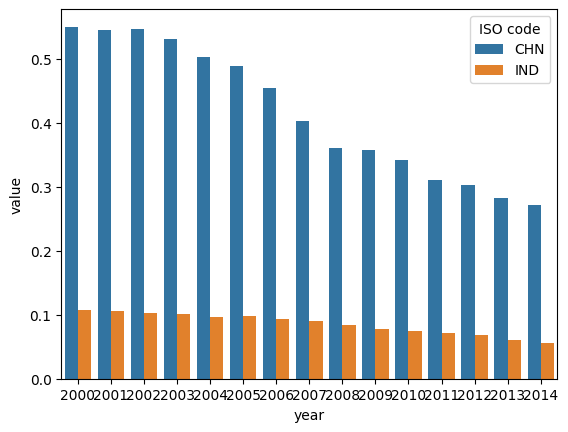

In [18]:
data_filter = PPP_exchage_filtered.loc[(PPP_exchage_filtered['ISO code'].isin(['IND','CHN']))]
sns.barplot(data=data_filter, x='year', y='value', hue='ISO code')

In [19]:
SEA.head()

,country,variable,code,year,value
0,AUS,CAP,A01,2000,9739.77
1,AUS,CAP,A02,2000,582.69
2,AUS,CAP,A03,2000,869.31
3,AUS,CAP,B,2000,28250.15
4,AUS,CAP,C10-C12,2000,6401.86


In [20]:
%%time

ind_ppps = []
for (country,year),dfx in tqdm(SEA.groupby(['country','year']), unit=' country'):
    X_ppp = PPP_exchage_filtered.loc[(PPP_exchage_filtered['year']==str(year)) & (PPP_exchage_filtered['ISO code']==country)]['value'].values[0]
    dfx['tot_ind_ppp'] = dfx['value']*X_ppp

    ind_ppps.append(dfx)

tot_ind_ppp_df = pd.concat(ind_ppps).reset_index()
tot_ind_ppp_df.head()

100%|██████████| 645/645 [00:01<00:00, 340.39 country/s]


CPU times: user 2.91 s, sys: 188 ms, total: 3.1 s
Wall time: 5.3 s


,index,country,variable,code,year,value,tot_ind_ppp
0,0,AUS,CAP,A01,2000,9739.77,10285.682219
1,1,AUS,CAP,A02,2000,582.69,615.349661
2,2,AUS,CAP,A03,2000,869.31,918.034657
3,3,AUS,CAP,B,2000,28250.15,29833.565426
4,4,AUS,CAP,C10-C12,2000,6401.86,6760.683011


<Axes: xlabel='year', ylabel='tot_ind_ppp'>

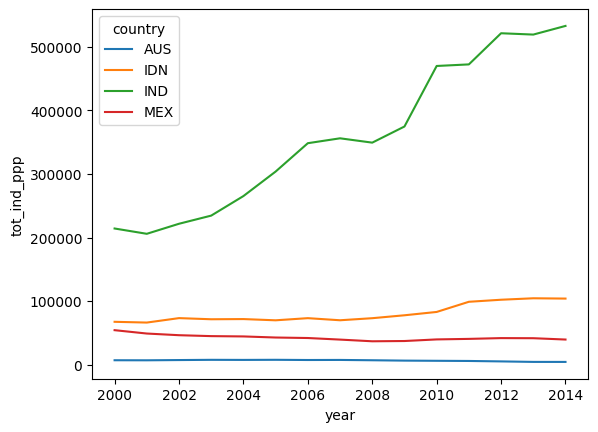

In [21]:
data_filter = tot_ind_ppp_df.loc[(tot_ind_ppp_df['country'].isin(['IND','AUS', 'IDN', "MEX"])) & (tot_ind_ppp_df['code']=='C13-C15') & (tot_ind_ppp_df['variable']=='GO')]
sns.lineplot(data=data_filter, x='year', y='tot_ind_ppp', hue='country')

In [22]:
tot_ind_ppp_df_GO = tot_ind_ppp_df[tot_ind_ppp_df['variable']=='GO']
tot_ind_ppp_df_GO = tot_ind_ppp_df_GO.groupby(['code','year']).sum().reset_index().drop(['country','value','variable','index'], axis=1)
tot_ind_ppp_df_GO.head()

,code,year,tot_ind_ppp
0,A01,2000,3.508316e+06
1,A01,2001,3.605992e+06
2,A01,2002,3.598810e+06
3,A01,2003,3.736123e+06
4,A01,2004,4.060107e+06


In [23]:
SEA_USD_x = pd.melt(SEA_USD, id_vars=['country', 'code', 'variable'], value_vars=year_range)
SEA_USD_x = SEA_USD_x.loc[SEA_USD_x['variable']=="GO"]
SEA_USD_x = SEA_USD_x.groupby(['code','year']).sum().reset_index().drop(['country','variable'], axis=1)

SEA_USD_x['SEA_by_PPP'] = SEA_USD_x['value']/tot_ind_ppp_df_GO['tot_ind_ppp']
SEA_USD_x.drop('value', axis=1, inplace=True)
print(SEA_USD_x.shape)
SEA_USD_x.head(5)

(840, 3)


,code,year,SEA_by_PPP
0,A01,2000,0.364607
1,A01,2001,0.354486
2,A01,2002,0.359874
3,A01,2003,0.394123
4,A01,2004,0.420667


In [24]:
PPP_exchage_filtered.head()

,ISO code,Country,year,value
8,AUS,Australia,2000,1.056050
9,AUT,Austria,2000,1.447184
12,BEL,Belgium,2000,1.421313
16,BGR,Bulgaria,2000,2.679952
24,BRA,Brazil,2000,1.352885


In [25]:
%%time
ind_ex_rates = []
for (country,year),dfx in tqdm(PPP_exchage_filtered.groupby(['Country','year']), unit=' country'):
    ppp_ex = dfx['value'].values[0]
    sea_by_ppp_x = SEA_USD_x[SEA_USD_x['year']==int(year)].copy()
    sea_by_ppp_x['country'] = dfx['ISO code'].values[0]
    sea_by_ppp_x['ind_ppp_ex'] = sea_by_ppp_x['SEA_by_PPP']*ppp_ex

    ind_ex_rates.append(sea_by_ppp_x)

ind_ex_rate = pd.concat(ind_ex_rates).reset_index(drop=True)
ind_ex_rate.head()

100%|██████████| 645/645 [00:01<00:00, 590.54 country/s]

CPU times: user 1.15 s, sys: 24.7 ms, total: 1.17 s
Wall time: 1.18 s


,code,year,SEA_by_PPP,country,ind_ppp_ex
0,A01,2000,0.364607,AUS,0.385043
1,A02,2000,0.389933,AUS,0.411789
2,A03,2000,0.353583,AUS,0.373401
3,B,2000,0.432509,AUS,0.456751
4,C10-C12,2000,0.516493,AUS,0.545442


### Country Industry PPP

In [26]:
SEA_GO = SEA[SEA['variable']=="GO"].drop('variable',axis=1).copy()
country_ind_ppp = pd.merge(
    left=SEA_GO,
    right=ind_ex_rate,
    left_on = SEA_GO['country']+SEA_GO['code']+SEA_GO['year'].astype(str),
    right_on =ind_ex_rate['country']+ind_ex_rate['code']+ind_ex_rate['year'].astype(str),
    suffixes=('', '_y'),
    how='inner'
)


country_ind_ppp['country_ind_ppp'] = country_ind_ppp['value']*country_ind_ppp['ind_ppp_ex']

country_ind_ppp = country_ind_ppp.drop(['key_0', 'code_y','year_y','SEA_by_PPP', 'country_y'], axis=1)
country_ind_ppp.dropna(inplace=True)
country_ind_ppp.sample(5)

,country,code,year,value,ind_ppp_ex,country_ind_ppp
8805,LVA,C23,2003,93.000,1.591492,148.008776
27757,IRL,J59_J60,2011,623.000,1.346010,838.564056
24552,CYP,E36,2010,165.300,1.029169,170.121657
4204,NOR,C10-C12,2001,115081.000,0.082478,9491.611718
41,AUS,K65,2000,25934.239,0.718479,18633.206884


### World Industry Value

In [27]:
GO_industry_total = SEA_GO.groupby(['code','year']).sum().reset_index().drop(columns=['country'],axis=1)
GO_industry_total = GO_industry_total.rename(columns = {'value':'GO'})

SEA_HEMPE = SEA[SEA['variable']=="H_EMPE"].copy().drop(columns=['country', 'variable'],axis=1)
HEMPE_industry_total = SEA_HEMPE.groupby(['code','year']).sum().reset_index()
HEMPE_industry_total = HEMPE_industry_total.rename(columns = {'value':'H_EMPE'})

HEMPE_GO_ind_total = HEMPE_industry_total.set_index(['code','year']).join(GO_industry_total.set_index(['code','year'])).reset_index()
HEMPE_GO_ind_total.sample(3)

,code,year,H_EMPE,GO
382,E37-E39,2007,3218.9010,1.280271e+07
664,M69_M70,2004,18440.1720,4.140615e+07
684,M71,2009,11515.4516,2.566416e+07


In [28]:
%%time
world_industry_values = []
for country,dfx in tqdm(country_ind_ppp.groupby(['country']), unit=' country'):
    world_industry_value = pd.merge(
        left=dfx,
        right=HEMPE_GO_ind_total,
        left_on = dfx['code']+dfx['year'].astype(str),
        right_on =HEMPE_GO_ind_total['code']+HEMPE_GO_ind_total['year'].astype(str),
        suffixes=('', '_y'),
        how='inner'
    )

    world_industry_value = world_industry_value.drop(['key_0', 'code_y','year_y'], axis=1)

    world_industry_values.append(world_industry_value)

world_industry_values = pd.concat(world_industry_values).reset_index(drop=True)
world_industry_values.head()

100%|██████████| 43/43 [00:00<00:00, 195.74 country/s]

CPU times: user 238 ms, sys: 3.21 ms, total: 242 ms
Wall time: 246 ms


,country,code,year,value,ind_ppp_ex,country_ind_ppp,H_EMPE,GO
0,AUS,A01,2000,49709.210,0.385043,19140.186311,260801.8294,2.818576e+08
1,AUS,A02,2000,2586.232,0.411789,1064.981635,25176.0964,2.897634e+07
2,AUS,A03,2000,2597.053,0.373401,969.741863,12209.6857,3.470360e+07
3,AUS,B,2000,58406.047,0.456751,26677.002857,11952.2797,2.062574e+08
4,AUS,C10-C12,2000,58673.688,0.545442,32003.105786,38579.8683,4.026327e+08


### Calculate homogeneous Labour

In [29]:
world_industry_values['hom_labour'] = world_industry_values['country_ind_ppp']*world_industry_values['H_EMPE']/world_industry_values['GO']
world_industry_values.head()

,country,code,year,value,ind_ppp_ex,country_ind_ppp,H_EMPE,GO,hom_labour
0,AUS,A01,2000,49709.210,0.385043,19140.186311,260801.8294,2.818576e+08,17.710345
1,AUS,A02,2000,2586.232,0.411789,1064.981635,25176.0964,2.897634e+07,0.925310
2,AUS,A03,2000,2597.053,0.373401,969.741863,12209.6857,3.470360e+07,0.341182
3,AUS,B,2000,58406.047,0.456751,26677.002857,11952.2797,2.062574e+08,1.545888
4,AUS,C10-C12,2000,58673.688,0.545442,32003.105786,38579.8683,4.026327e+08,3.066506


In [31]:
world_industry_values.to_excel('world_industry_values.xlsx')

### Plotting Homogeneous Labour in $

<Axes: xlabel='year', ylabel='hom_labour'>

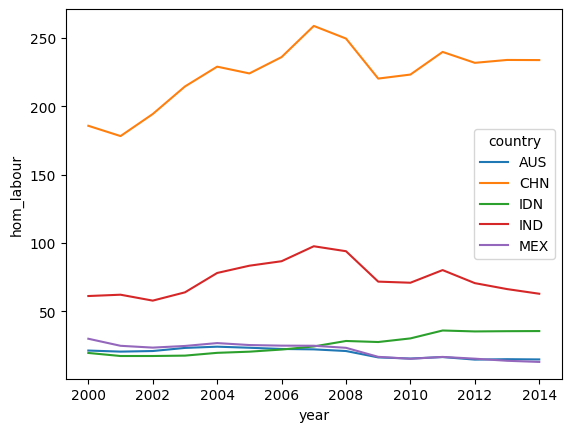

In [46]:
countries = ['IND','AUS', 'IDN', "MEX", "CHN"]
data_filter = world_industry_values.loc[(world_industry_values['country'].isin(countries)) & (world_industry_values['code']=='F')]
sns.lineplot(data=data_filter, x='year', y='hom_labour', hue='country')

## International Market Value (MV)


In [62]:
SEA_USD_GO

,year,value
0,2000,5.594738e+07
1,2001,5.536669e+07
2,2002,5.758435e+07
3,2003,6.501111e+07
4,2004,7.369079e+07
5,2005,8.042558e+07
6,2006,8.750179e+07
7,2007,9.929350e+07
8,2008,1.097278e+08
9,2009,1.012481e+08


In [61]:
SEA_USD_melt = pd.melt(SEA_USD, id_vars=['country','variable','code'], value_vars= year_range, var_name='year')
SEA_USD_GO = SEA_USD_melt[['variable', 'value','year']][SEA_USD_melt['variable']=='GO'].groupby('year').sum().drop('variable', axis=1).reset_index()
SEA_HEMPE_sum = SEA[['variable', 'value','year']][SEA['variable']=='GO'].groupby('year').sum().drop('variable', axis=1).reset_index()

MEV = SEA_HEMPE_sum.copy().drop(['value'],axis=1)
MEV['MEV'] = SEA_USD_GO['value']/SEA_HEMPE_sum['value']
MEV

,year,MEV
0,2000,0.010346
1,2001,0.009135
2,2002,0.008684
3,2003,0.009094
4,2004,0.009225
5,2005,0.008834
6,2006,0.008342
7,2007,0.008294
8,2008,0.007608
9,2009,0.006472


## World Input Output Analysis

In [38]:
# hours = SEA[SEA['variable']=='H_EMPE'].copy().drop(['country','variable'],axis=1)
# hours = hours.groupby(['year','code']).sum().reset_index()
# hours.sample(4)

In [39]:
# %%time

# hom_labours = []
# for country,dfx in tqdm(hom_labour2.groupby('country'), unit=' country'):

#     x_merge = pd.merge(left = dfx,
#         right=hours,
#         left_on=dfx['year'].astype(str)+dfx['code'],
#         right_on=hours['year'].astype(str)+hours['code'],
#         how='inner',
#         suffixes=('', '_y')
#     )

#     x_merge['hom_labour'] = x_merge['h2']*x_merge['value']
#     x_merge = x_merge.drop(['key_0','code_y', 'year_y', 'value','h2','h3'], axis=1)

#     hom_labours.append(x_merge)

# hom_labour3 = pd.concat(hom_labours)
# hom_labour3.sample(5)

In [40]:
# data_filter = hom_labour3.loc[(hom_labour3['country'].isin(['IND','CHN','AUS', 'IDN', "MEX"])) & (hom_labour3['code']=='C13-C15')]
# sns.lineplot(data=data_filter, x='year', y='hom_labour', hue='country')

## Input Output Tables

In [41]:
# %%time
# df = pd.read_excel('WIOT2000_Nov16_ROW.xlsb', engine='pyxlsb')

In [42]:
# df.head(10)

In [43]:
# industries = df.iloc[5:, :3].reset_index(drop=True).copy()
# industries.columns = ['code', 'industry', 'country']
# print('Total number of industries',industries.shape[0])
# industries

In [44]:
# value = df.iloc[5:, 4:industries.shape[0]+4].copy()
# value.columns = industries['code']
# value['industry'] = industries['code']
# value['country'] = industries['country']
# value.sample(5)

In [45]:
# isProductive = ['K64', 'K65', 'K66', 'L68', 'M69_M70', 'N', 'O84', 'T', 'U']

# value[value['industry'].isin(isProductive)].groupby('country').sum().iloc[:,:-1].sum(axis=1)